# Octo Dataloading Examples

This notebook will walk you through some of the primary features of the Octo dataloader. Data is, after all, the most important part of any machine learning pipeline!

## Loading Open X-Embodiment Data

The [Open X-Embodiment (OXE)](https://robotics-transformer-x.github.io/) project was a massive cross-instutition data collection collaboration the likes of which robot learning has never seen before. The resulting dataset includes 22 different robots demonstrating 527 skills and totals over 1 million trajectories. However, as we found throughout the course of the Octo project, simply loading such a diverse set of robot data is no small feat. We hope that the `octo.data` pipeline can help kickstart anyone who hopes to take advantage of the massive collection of robot demonstrations that is OXE!

### Minimum working example to load a single OXE dataset

In [2]:
import numpy as np
import tensorflow as tf
import random

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

2024-05-31 21:43:49.413058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 21:43:49.413217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 21:43:49.415256: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-31 21:43:49.427397: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 21:43:51.126208: W tensorflow/compiler/tf2

In [10]:
# minimum working example to load a single OXE dataset
from pprint import pprint
from octo.data.oxe import make_oxe_dataset_kwargs
from octo.data.dataset import make_single_dataset

dataset_kwargs = make_oxe_dataset_kwargs(
    # see octo/data/oxe/oxe_dataset_configs.py for available datasets
    # (this is a very small one for faster loading)
    "bridge",
    # can be local or on cloud storage (anything supported by TFDS)
    # "/path/to/base/oxe/directory",
    "/home/marcelr/tensorflow_datasets",
)

dataset_kwargs["shuffle"] = False
dataset_kwargs["num_parallel_reads"] = 1
dataset_kwargs["num_parallel_calls"] = 1

pprint(dataset_kwargs)

dataset = make_single_dataset(
    dataset_kwargs,
    traj_transform_kwargs=dict(
        action_horizon=10,
        skip_unlabeled=True,
    ),
    train=True,
)
# dataset = dataset[:1]
iterator = dataset.iterator()

{'action_normalization_mask': [True, True, True, True, True, True, False],
 'action_proprio_normalization_type': <NormalizationType.NORMAL: 'normal'>,
 'data_dir': '/home/marcelr/tensorflow_datasets',
 'image_obs_keys': {'primary': 'image_0'},
 'language_key': 'language_instruction*',
 'name': 'bridge',
 'num_parallel_calls': 1,
 'num_parallel_reads': 1,
 'shuffle': False,
 'standardize_fn': {'args': (),
                    'kwargs': {},
                    'module': 'octo.data.oxe.oxe_standardization_transforms',
                    'name': 'bridge_transform'}}


2024-05-31 21:44:44.229310: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2024-05-31 21:44:45.170248: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


In [11]:
# make_single_dataset yields entire trajectories
traj = next(iterator)
print("Top-level keys: ", traj.keys())
print("Observation keys: ", traj["observation"].keys())
print("Task keys: ", traj["task"].keys())

Top-level keys:  dict_keys(['observation', 'task', 'action', 'dataset_name', 'action_pad_mask'])
Observation keys:  dict_keys(['image_primary', 'timestep', 'pad_mask_dict', 'timestep_pad_mask', 'task_completed'])
Task keys:  dict_keys(['language_instruction', 'pad_mask_dict'])


(38, 1, 480, 640, 3)
array([b'Move the blue sponge 157 pixels to the left and 69 pixels forward',
       b'Move the blue sponge 157 pixels to the left and 69 pixels forward',
       b'Move the blue sponge 157 pixels to the left and 69 pixels forward',
       b'Move the blue sponge 157 pixels to the left and 69 pixels forward',
       b'Move the blue sponge 157 pixels to the left and 69 pixels forward',
       b'Move the blue sponge 157 pixels to the left and 69 pixels forward',
       b'Move the blue sponge 157 pixels to the left and 69 pixels forward',
       b'Move the blue sponge 157 pixels to the left and 69 pixels forward',
       b'Move the blue sponge 157 pixels to the left and 69 pixels forward',
       b'Move the blue sponge 157 pixels to the left and 69 pixels forward',
       b'Move the blue sponge 157 pixels to the left and 69 pixels forward',
       b'Move the blue sponge 157 pixels to the left and 69 pixels forward',
       b'Move the blue sponge 157 pixels to the left an

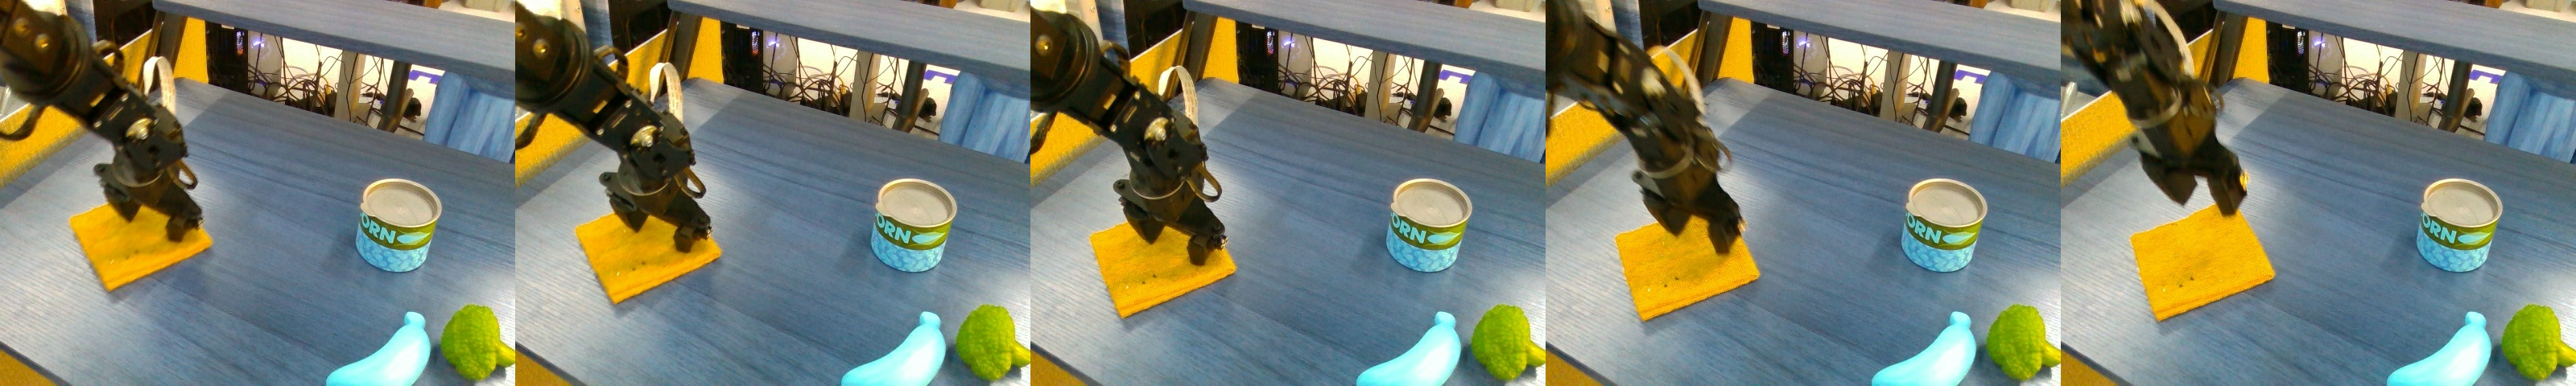

In [20]:
from PIL import Image
import numpy as np

traj = next(iterator)
images = traj["observation"]["image_primary"]
# should be: (traj_len, window_size, height, width, channels)
# (window_size defaults to 1)
print(images.shape)
# print(traj["observation"]["proprio"])
# for i in traj["action"]:
#     print(i[..., :3])
pprint(traj["task"]["language_instruction"])
# pprint([a.decode("utf-8") for a in traj["task"]["language_instruction"]])
Image.fromarray(np.concatenate(images.squeeze()[-5:], axis=1))

In [ ]:
# you should set these much higher in practice (as large as your memory can hold!)
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64

# turning a dataset of trajectories into a training-ready batched dataset
train_dataset = (
    dataset.flatten() # flattens trajectories into individual frames
    .shuffle(SHUFFLE_BUFFER_SIZE) # shuffles the frames
    .batch(BATCH_SIZE) # batches the frames
)
batch = next(train_dataset.iterator())
images = batch["observation"]["image_primary"]
# should be: (batch_size, window_size, height, width, channels)
print(images.shape)
Image.fromarray(np.concatenate(images.squeeze()[:5], axis=1))

### Loading a training-ready OXE mix

In reality, you're probably going to want to mix multiple datasets together, as well as use other transformations such as resizing, augmentation, windowing, etc. This section will show you how to get a proper OXE mix up and running, as well as demonstrate additional `octo.data` features for more realistic use-cases.

In [ ]:
from octo.data.oxe import make_oxe_dataset_kwargs_and_weights
from octo.data.dataset import make_interleaved_dataset

dataset_kwargs_list, sample_weights = make_oxe_dataset_kwargs_and_weights(
    # you can pass your own list of dataset names and sample weights here, but we've
    # also provided a few named mixes for convenience. The Octo model was trained
    # using the "oxe_magic_soup" mix.
    "rtx",
    # can be local or on cloud storage (anything supported by TFDS)
    "gs://gresearch/robotics",
    # let's get a wrist camera!
    load_camera_views=("primary", "wrist"),
)

# see `octo.data.dataset.make_dataset_from_rlds` for the meaning of these kwargs
dataset_kwargs_list[0]

In [ ]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 8

# each element of `dataset_kwargs_list` can be used with `make_single_dataset`, but let's
# use the more powerful `make_interleaved_dataset` to combine them for us!
dataset = make_interleaved_dataset(
    dataset_kwargs_list,
    sample_weights,
    train=True,
    # unlike our manual shuffling above, `make_interleaved_dataset` will shuffle
    # the JPEG-encoded images, so you should be able to fit a much larger buffer size
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    # see `octo.data.dataset.apply_trajectory_transforms` for full documentation
    # of these configuration options
    traj_transform_kwargs=dict(
        goal_relabeling_strategy="uniform",  # let's get some goal images
        window_size=2,  # let's get some history
        action_horizon=4,  # let's get some future actions for action chunking
        subsample_length=100,  # subsampling long trajectories improves shuffling a lot
    ),
    # see `octo.data.dataset.apply_frame_transforms` for full documentation
    # of these configuration options
    frame_transform_kwargs=dict(
        # let's apply some basic image augmentations -- see `dlimp.transforms.augment_image`
        # for full documentation of these configuration options
        image_augment_kwargs=dict(
            primary=dict(
                augment_order=["random_resized_crop", "random_brightness"],
                random_resized_crop=dict(scale=[0.8, 1.0], ratio=[0.9, 1.1]),
                random_brightness=[0.1],
            )
        ),
        # providing a `resize_size` is highly recommended for a mixed dataset, otherwise
        # datasets with different resolutions will cause errors
        resize_size=dict(
            primary=(256, 256),
            wrist=(128, 128),
        ),
        # If parallelism options are not provided, they will default to tf.Data.AUTOTUNE.
        # However, we would highly recommend setting them manually if you run into issues
        # with memory or dataloading speed. Frame transforms are usually the speed
        # bottleneck (due to image decoding, augmentation, and resizing), so you can set
        # this to a very high value if you have a lot of CPU cores. Keep in mind that more
        # parallel calls also use more memory, though.
        num_parallel_calls=64,
    ),
    # Same spiel as above about performance, although trajectory transforms and data reading
    # are usually not the speed bottleneck. One reason to manually set these is if you want
    # to reduce memory usage (since autotune may spawn way more threads than necessary).
    traj_transform_threads=16,
    traj_read_threads=16,
)

# Another performance knob to tune is the number of batches to prefetch -- again,
# the default of tf.data.AUTOTUNE can sometimes use more memory than necessary.
iterator = dataset.iterator(prefetch=1)

In [ ]:
# phew, that was a lot of configuration! Let's see what we got.
batch = next(iterator)
print("Top-level keys: ", batch.keys())
# should now have "image_primary" and "image_wrist"!
print("Observation keys: ", batch["observation"].keys())
# should also have "image_primary" and "image_wrist", corresponding to future goal images
print("Task keys: ", batch["task"].keys())

In [ ]:
from PIL import Image
import numpy as np

images_primary = batch["observation"]["image_primary"]
images_wrist = batch["observation"]["image_wrist"]
# should be: (batch_size, window_size (now 2), height, width, channels)
print(images_primary.shape)
print(images_wrist.shape)
actions = batch["action"]
# should be: (batch_size, window_size, action_horizon, action_dim)
print(actions.shape)

In [ ]:
# let's visualize a window of primary images
display(Image.fromarray(np.concatenate(images_primary[0], axis=1)))
# now a window of wrist images -- many datasets don't have wrist images,
# so this will often be black
display(Image.fromarray(np.concatenate(images_wrist[0], axis=1)))
# pad_mask_dict also tells you which keys should be treated as padding
# (e.g., if the wrist camera is black, the corresponding pad_mask_dict entry is False)
print(batch["observation"]["pad_mask_dict"]["image_wrist"][0])

In [ ]:
# let's take a look at the "task" dict: it should now have both goal
# images and language instructions!
goal_primary = batch["task"]["image_primary"]
goal_wrist = batch["task"]["image_wrist"]
language_instruction = batch["task"]["language_instruction"]
display(Image.fromarray(goal_primary[0]))
display(Image.fromarray(goal_wrist[0]))
print(language_instruction[0])